# This Notebook contains the code to perform Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
from sklearn.metrics import accuracy_score,auc,confusion_matrix,classification_report,precision_score,roc_curve,roc_auc_score,recall_score,f1_score,precision_score
from sklearn import metrics
import missingno as mn
import math as m
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_palette('husl',8)

#### Reading the cleaned & merged dataset

In [2]:
sales_forecasting_df = pd.read_csv("data/sales_forecasting.csv")
print(sales_forecasting_df.head())
print(sales_forecasting_df.shape)

   Store  Dept        Date  Weekly_Sales    Size  Type_A  Type_B  Type_C  \
0      1     1  2010-02-05      24924.50  151315       1       0       0   
1      1     1  2010-02-12      46039.49  151315       1       0       0   
2      1     1  2010-02-19      41595.55  151315       1       0       0   
3      1     1  2010-02-26      19403.54  151315       1       0       0   
4      1     1  2010-03-05      21827.90  151315       1       0       0   

   Temperature  Fuel_Price         CPI  Unemployment  IsHoliday  
0        42.31       2.572  211.096358         8.106          0  
1        38.51       2.548  211.242170         8.106          1  
2        39.93       2.514  211.289143         8.106          0  
3        46.63       2.561  211.319643         8.106          0  
4        46.50       2.625  211.350143         8.106          0  
(421570, 13)


### 1. Viewing the average sales across the 3 store types

In [3]:
store_type = ['A','B','C']
average_sales = [sales_forecasting_df.loc[sales_forecasting_df['Type_A'] == 1, 'Weekly_Sales'].sum()/sales_forecasting_df.Type_A.sum(),
                 sales_forecasting_df.loc[sales_forecasting_df['Type_B'] == 1, 'Weekly_Sales'].sum()/sales_forecasting_df.Type_B.sum(),
                 sales_forecasting_df.loc[sales_forecasting_df['Type_C'] == 1, 'Weekly_Sales'].sum()/sales_forecasting_df.Type_C.sum()]

*Stores of Type A, have a much higher average sales than types B & C*
##### *Hence, Store Size would also have an impact on Sales, as the store types A, B & C represent the 3 categories of store sizes*

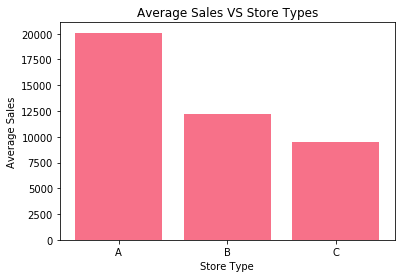

In [4]:
plt.bar(store_type, average_sales, align='center')
plt.title('Average Sales VS Store Types')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()

### 2. Viewing the average sales across Holiday week & Non Holiday week categories

In [5]:
Holiday_week = ['Yes','No']
average_sales = [sales_forecasting_df.loc[sales_forecasting_df['IsHoliday'] == 1, 'Weekly_Sales'].sum()/sales_forecasting_df.IsHoliday.sum(),
                 sales_forecasting_df.loc[sales_forecasting_df['IsHoliday'] == 0, 'Weekly_Sales'].sum()/(len(sales_forecasting_df)-sales_forecasting_df.IsHoliday.sum())]

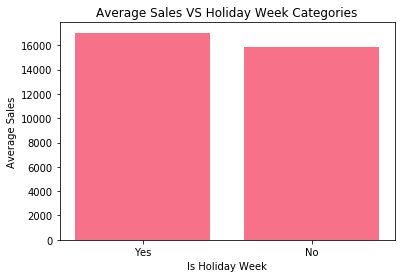

In [6]:
plt.bar(Holiday_week, average_sales, align='center')
plt.title('Average Sales VS Holiday Week Categories')
plt.xlabel('Is Holiday Week')
plt.ylabel('Average Sales')
plt.show()

### 3. Total Weekly Sales at a Store level

We can observe a fluctuating seasonal trend across all the 45 stores. As expected, we see a huge peak in sales during the months of November & December every year

In [20]:
sales_week_store_lvl = sales_forecasting_df.groupby(['Store', 'Date'],as_index=False).agg({'Weekly_Sales': ['sum']})
sales_week_store_lvl.columns = ["_".join(x) for x in sales_week_store_lvl.columns.ravel()]

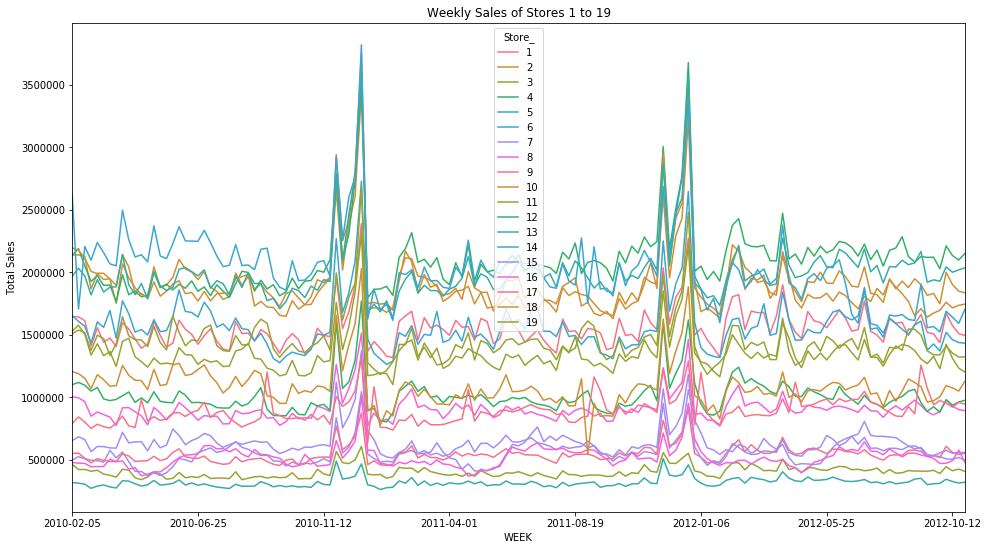

In [48]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
sales_week_store_lvl[(sales_week_store_lvl.Store_ >= 1) & (sales_week_store_lvl.Store_ <20)].pivot(index="Date_", columns="Store_", values="Weekly_Sales_sum").plot()
plt.xlabel('WEEK')
plt.ylabel('Total Sales')
plt.title('Weekly Sales of Stores 1 to 19')
plt.show()

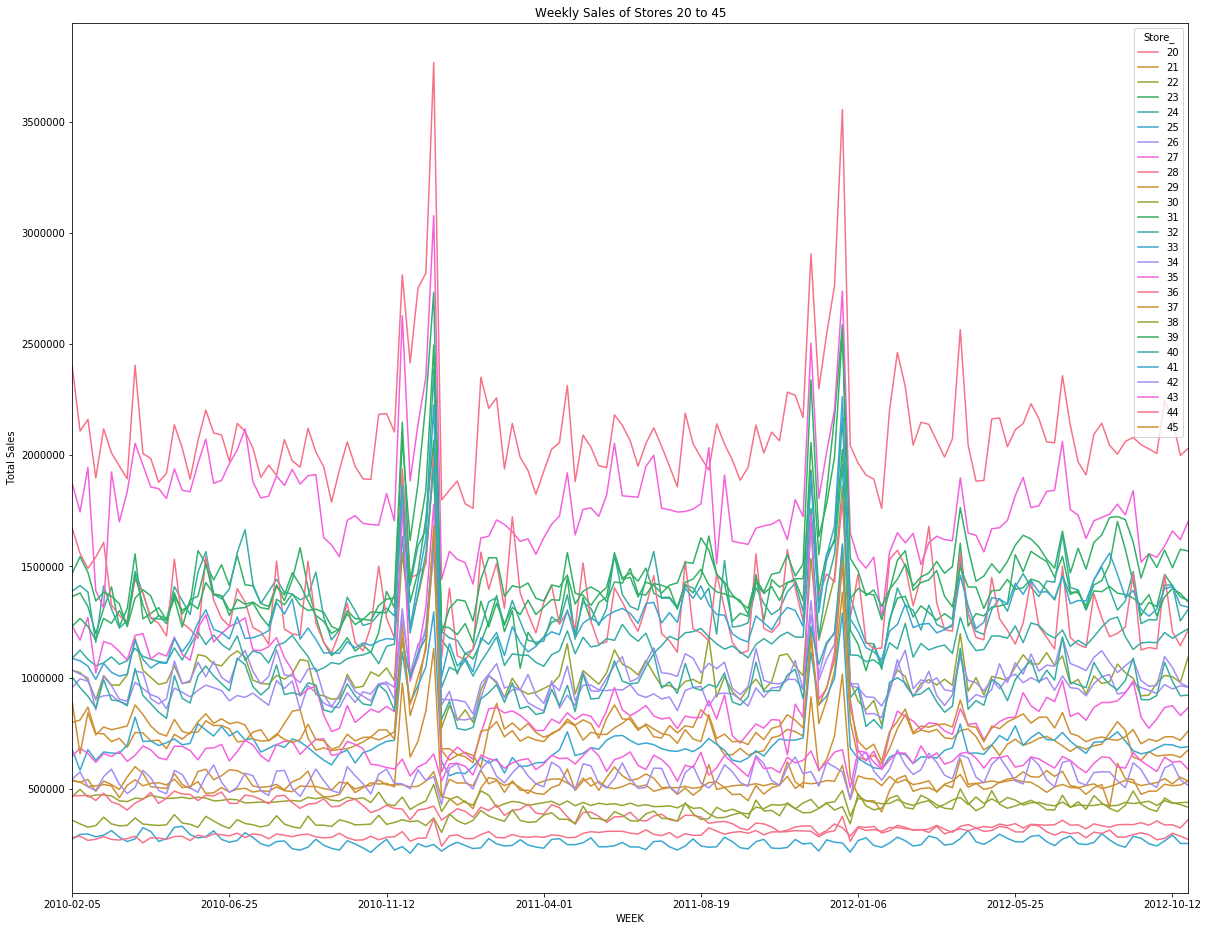

In [50]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20,16]
sales_week_store_lvl[(sales_week_store_lvl.Store_ >= 20)].pivot(index="Date_", columns="Store_", values="Weekly_Sales_sum").plot()
plt.xlabel('WEEK')
plt.ylabel('Total Sales')
plt.title('Weekly Sales of Stores 20 to 45')
plt.show()

In [52]:
sales_week_store_lvl.head()

,Store_,Date_,Weekly_Sales_sum
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68


In [53]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


*Joining back the rolled up table with features table to pull the explanatory attributes*

In [60]:
features_df = pd.read_csv("data/features.csv")
#features_df['Date'] = pd.to_datetime(features_df.Date)
week_store_sales_attri = pd.merge(sales_week_store_lvl,features_df, how = 'inner', left_on=['Store_','Date_'], right_on = ['Store','Date'])

In [61]:
week_store_sales_attri = week_store_sales_attri.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
week_store_sales_attri.head()

,Store_,Date_,Weekly_Sales_sum,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,2010-02-05,1643690.90,1,2010-02-05,42.31,2.572,211.096358,8.106,False
1,1,2010-02-12,1641957.44,1,2010-02-12,38.51,2.548,211.242170,8.106,True
2,1,2010-02-19,1611968.17,1,2010-02-19,39.93,2.514,211.289143,8.106,False
3,1,2010-02-26,1409727.59,1,2010-02-26,46.63,2.561,211.319643,8.106,False
4,1,2010-03-05,1554806.68,1,2010-03-05,46.50,2.625,211.350143,8.106,False


#### Correlation Matrix between Target Variable (Sales) and other explanatory Numeric Variable
*Fuel Price is least Correlated with Sales (Almost uncorrelated). Unemployment, Temperature & CPI are negatively correlated with Sales*

In [67]:
corrMatrix = week_store_sales_attri[['Weekly_Sales_sum','Temperature','Fuel_Price','CPI','Unemployment']].corr()
corrMatrix

,Weekly_Sales_sum,Temperature,Fuel_Price,CPI,Unemployment
Weekly_Sales_sum,1.000000,-0.063810,0.009464,-0.072634,-0.106176
Temperature,-0.063810,1.000000,0.144982,0.176888,0.101158
Fuel_Price,0.009464,0.144982,1.000000,-0.170642,-0.034684
CPI,-0.072634,0.176888,-0.170642,1.000000,-0.302020
Unemployment,-0.106176,0.101158,-0.034684,-0.302020,1.000000
